## Import library

In [1]:
# PyTorch 라이브러리 임포트
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from os import walk
import matplotlib.pyplot as plt

# scikit-learn 라이브러리 임포트
from sklearn.model_selection import train_test_split

## Preparing the Dataset

In [2]:
##Place all the npy quickdraw files here:
mypath = "data/"
txt_name_list = []
for (dirpath, dirnames, filenames) in walk(mypath):
    if filenames != 'Aa':       ##Ugh mac junk
        txt_name_list.extend(filenames)
        break

In [3]:
x_train = []
x_test = []
y_train = []
y_test = []
xtotal = []
ytotal = []
slice_train = int(80000/len(txt_name_list))  ###Setting value to be 80000 for the final dataset
i = 0
seed = np.random.randint(1, 10e6)

In [4]:
##Creates test/train split with quickdraw data
for txt_name in txt_name_list:
    txt_path = mypath + txt_name
    x = np.load(txt_path)
    x = x.astype('float32') / 255.    ##scale images
    y = [i] * len(x)  
    np.random.seed(seed)
    np.random.shuffle(x)
    np.random.seed(seed)
    np.random.shuffle(y)
    x = x[:slice_train]
    y = y[:slice_train]
    if i != 0: 
        xtotal = np.concatenate((x,xtotal), axis=0)
        ytotal = np.concatenate((y,ytotal), axis=0)
    else:
        xtotal = x
        ytotal = y
    i += 1

In [5]:
# 훈련 데이터 건수
train_size = 5000
# 테스트 데이터 건수
test_size = 500
train_X, test_X, train_Y, test_Y = train_test_split(
    xtotal, ytotal, train_size=train_size,test_size=test_size)

In [6]:
# 길이가 784인 1차원 배열을 28*28 크기의 2차원 배열로 만듬
train_X = train_X.reshape((len(train_X), 1, 28, 28))
test_X = test_X.reshape((len(test_X), 1, 28, 28))

In [7]:
# 훈련 데이터 텐서 변환
train_X = torch.from_numpy(train_X).float()
train_Y = torch.from_numpy(train_Y).long()

# 테스트 데이터 텐서 변환
test_X = torch.from_numpy(test_X).float()
test_Y = torch.from_numpy(test_Y).long()

In [8]:
# 설명변수와 목적변수 텐서를 합침
train = TensorDataset(train_X, train_Y)

# 미니배치 분할
train_loader = DataLoader(train, batch_size=100, shuffle=True)

## Building the Network

In [9]:
# 신경망 구성
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 합성곱층
        self.conv1 = nn.Conv2d(1, 6, 5) # 입력 채널 수, 출력 채널 수, 필터 크기
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 전결합층
        self.fc1 = nn.Linear(256, 64) # 256 = (((28-5+1)/2 )-5+1)/2 * (((28-5+1)/2 )-5+1)/2 * 16
        self.fc2 = nn.Linear(64, 10)
    
    def forward(self, x):
        # 풀링층
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) # 풀링 영역 크기
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)
    
# 인스턴스 생성
model = Net()

## Training the Model

In [10]:
# 오차함수 객체
criterion = nn.CrossEntropyLoss()

# 최적화를 담당할 객체
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 학습 시작
for epoch in range(1000):
    total_loss = 0
    # 분할해 둔 데이터를 꺼내옴
    for train_x, train_y in train_loader:
        # 계산 그래프 구성
        # 경사 초기화
        optimizer.zero_grad()
        # 순전파 계산
        output = model(train_x)
        # 오차계산
        loss = criterion(output, train_y)
        # 역전파 계산
        loss.backward()
        # 가중치 업데이트
        optimizer.step()
        # 누적 오차 계산
        total_loss += loss.item()
    # 100회 반복마다 누적 오차 출력
    if (epoch+1) % 100 == 0:
        print(epoch+1, total_loss)

F:\Anaconda3\envs\pytlesson\lib\site-packages\ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


100 tensor(3.3264)
200 tensor(2.0723)
300 tensor(1.3053)
400 tensor(0.7121)
500 tensor(0.3301)
600 tensor(0.2056)
700 tensor(0.0933)
800 tensor(0.0584)
900 tensor(0.0442)
1000 tensor(0.0320)


## Evaluating the Model's Performance

In [11]:
# 계산 그래프 구성
test_x, test_y = Variable(test_X), Variable(test_Y)
# 출력이 0 혹은 1이 되게 함
result = torch.max(model(test_x).data, 1)[1]
# 모형의 정확도 측정
accuracy = sum(test_y.data.numpy() == result.numpy()) / len(test_y.data.numpy())

# 모형의 정확도 출력
accuracy

0.972

## Test a example

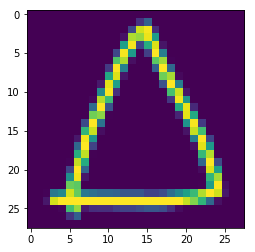

torch.Size([1, 1, 28, 28])
[2]


In [12]:
#example하나 선택
ex = xtotal[4558]
ex1 = ex.reshape(28,28)
plt.imshow(ex1)
plt.show()

ex_X = ex.reshape(1,1,28, 28)
ex_X = torch.from_numpy(ex_X).float()
print(ex_X.shape)

# 출력이 0 혹은 1이 되게 함
result = torch.max(model(ex_X).data, 1)[1]

#result 출력
print(result.numpy())